<a href="https://colab.research.google.com/github/Derniska/MyProject/blob/master/gradient_boosting_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost -q
!pip install opencv-python shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.1 MB/s eta 0:00:00


***Дополнительные условия:***

- Все модели обучаем на 3-х фолдах.
- Выбираем лучший фолд от каждой модели (получаем 3 лучших модели).
- Обязательно должна быть добавлена ячейка с сохранением 3-х лучших моделей.
- Делаем итоговое предсказание на тестовом датасете, усреднив предсказание от 3-х лучших моделей.
- Сохраняем в submission.csv только колонки car_id и target_reg.
- В конце добавляем небольшой текстовый блок с выводами.
- Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.
- Не добавляем новые признаки.
- Не используем GPU.
- Не используем Optuna.

***Что можно использовать (но не обязательно)?***

- Feature Selection.
- Object importance.
- Подбор гиперпараметров.
- Графику.
- Колбэки, шедулеры, кастомы

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor as cb, Pool
from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgbm
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.inspection import permutation_importance

In [3]:
SEED = 75

In [4]:
train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv')

In [5]:
train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [6]:
test.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,gear_stick,3.746207,1.407539e+07,0.10,195.454152,10.566220,174,170
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016,engine_overheat,4.318966,1.970390e+07,0.00,181.538685,11.807941,174,174
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,electro_bug,5.134655,9.314946e+06,0.10,118.440645,14.862538,174,172
3,F12725233R,Smart ForFour,economy,petrol,2.80,2014,68833,2021,engine_check,4.617356,9.336838e+06,0.83,112.829785,20.088904,174,172
4,l-1139189J,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,another_bug,4.287471,1.196250e+07,0.00,187.846088,3.698460,174,172


In [7]:
print(f'Размерность тренировочного дататсета {train.shape}\nРазмерность тестового дататсета {test.shape}')

Размерность тренировочного дататсета (2337, 17)
Размерность тестового дататсета (1913, 16)


# СatboostRegressor

In [8]:
cat_features = ['model', 'car_type', 'fuel_type']
target = ['target_reg']
features2drop = ['target_class', 'car_id']
filtered_features = [col for col in train.columns if (col not in target and col not in features2drop)]
num_features = [col for col in filtered_features if col not in cat_features]

In [9]:
# Baseline
n_splits = 3
regressions = []
scores = []
X = train[filtered_features].drop(target, axis=1, errors="ignore")
y = train[target]
kf = KFold(n_splits = n_splits, shuffle = True, random_state = 75)
for train_index, val_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[val_index]
  y_train, y_test = y.iloc[train_index], y.iloc[val_index]
  train_dataset = Pool(data = X_train, label = y_train, cat_features = cat_features)
  test_dataset = Pool(data = X_test, label = y_test, cat_features = cat_features)

  regressor = cb(
      depth = 4,
      iterations=500,
      learning_rate=0.06,
      loss_function= "MAE",
      eval_metric = "RMSE",

      colsample_bylevel=0.098,
      subsample=0.95,
      l2_leaf_reg=9,
      min_data_in_leaf=243,
      max_bin=187,
      random_strength=1,

      cat_features = cat_features,
      # ignored_features = [0],
      task_type="CPU",
      thread_count=-1,
      bootstrap_type="Bernoulli",

      random_seed=SEED,
      early_stopping_rounds=50
    )
  regressions.append(regressor)
  regressor.fit(
      train_dataset,
      eval_set = test_dataset,
      verbose=500,
      use_best_model=True,
      plot=False
  )
  scores.append(np.mean([v for k, v in regressor.best_score_['validation'].items() if 'RMSE' in k], dtype = 'float16'))
assert(len(regressions)) == len(scores)
print("mean RMSE score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))
best_regressor = regressions[scores.index(np.max(scores))]


0:	learn: 18.4378453	test: 18.3916210	best: 18.3916210 (0)	total: 48.1ms	remaining: 24s
499:	learn: 11.2852861	test: 11.8116844	best: 11.8072319 (467)	total: 621ms	remaining: 0us

bestTest = 11.80723195
bestIteration = 467

Shrink model to first 468 iterations.
0:	learn: 18.5948316	test: 17.5081923	best: 17.5081923 (0)	total: 1.27ms	remaining: 635ms
499:	learn: 11.1098405	test: 11.4790938	best: 11.4790938 (499)	total: 326ms	remaining: 0us

bestTest = 11.47909381
bestIteration = 499

0:	learn: 17.8212909	test: 18.9540616	best: 18.9540616 (0)	total: 4.8ms	remaining: 2.4s
499:	learn: 10.7361501	test: 12.6934942	best: 12.6931211 (494)	total: 1.16s	remaining: 0us

bestTest = 12.69312114
bestIteration = 494

Shrink model to first 495 iterations.
mean RMSE score ---------> 11.48


In [10]:
test['target_reg'] = best_regressor.predict(test[filtered_features])

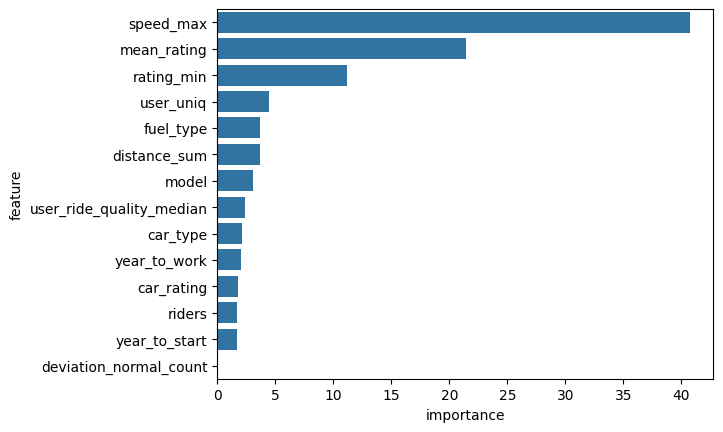

In [11]:
# Важность признаков для лучшей модели
ft_importances = best_regressor.get_feature_importance(prettified = True)
ft_importances.columns = ['feature', 'importance']
g = sns.barplot(data = ft_importances, y = 'feature', x = 'importance')


ValueError: List of boxplot statistics and `positions` values must have same the length

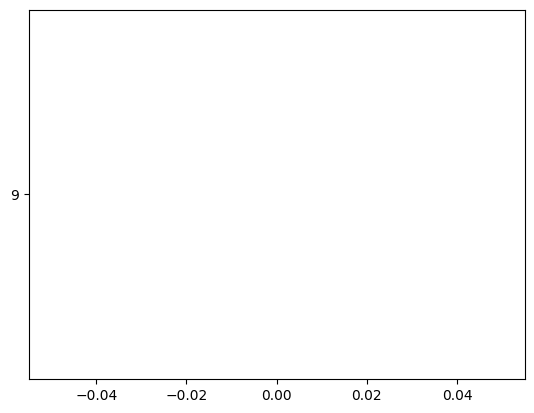

In [47]:
# Средняя важность признаков по трем фолдам
fi = pd.DataFrame(index = filtered_features, columns = [])
for i, model in enumerate(regressions):
  fi[f'm_{i}'] = model.get_feature_importance()
fi = fi.stack().reset_index().iloc[:, [0,2]]
fi.columns = ['feature', 'importance']
cols_ord = list(fi.groupby('feature', as_index= False)['importance'].mean().sort_values('importance', ascending = False).index)
sns.boxplot(data = fi, x = 'importance', y = 'feature', orient = 'h', order = cols_ord);

In [12]:
import shap
shap.initjs()

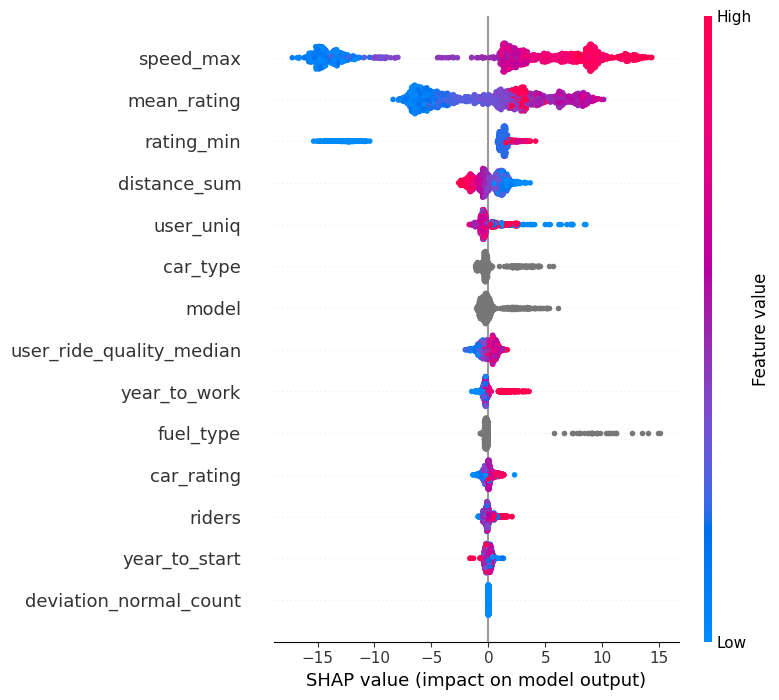

In [13]:
explainer = shap.TreeExplainer(best_regressor)

train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)

shap.summary_plot(shap_values, X_train, max_display=25)

In [16]:
# Regression plot
cb_prediction = best_regressor.predict(test[filtered_features])
df_pred = pd.DataFrame(cb_prediction, columns = ['predicted_values'])
df_pred['actual_values']  =

In [17]:
df_pred

,predicted_values
0,45.213427
1,32.723629
2,31.774620
3,34.853017
4,35.511758
...,...
1908,56.155429
1909,42.982840
1910,32.911205
1911,46.422084
